In [52]:
import pandas as pd
import numpy as np
import sklearn as sk

In [53]:
df1 = pd.read_csv("politifact_with_bio_data.csv")

In [54]:
df1.head()

,Unnamed: 0.1,index,Unnamed: 0,name,claim date,claim source,claim,issue,accuracy rating,id.bioguide,id.wikipedia,bio.gender,bio.birthday,type,party,start,end,state,full name,accuracy
0,0,2,2,Mark Kelly,"August 5, 2022",an ad,Blake Masters “wants to pass a national ban on...,abortion,mostly-true,K000377,Mark Kelly,M,21/2/1964,sen,Democrat,2/12/2020,3/1/2023,AZ,Mark Kelly,1
1,1,9,9,Mariannette Miller-Meeks,"July 17, 2022",a newsletter,The Democrats’ Women’s Health Protection Act o...,abortion,barely-true,M001215,Mariannette Miller-Meeks,F,6/9/1955,rep,Republican,3/1/2021,3/1/2023,IA,Mariannette Miller-Meeks,0
2,2,25,25,Catherine Cortez Masto,"June 14, 2022",an ad,"Adam Laxalt ""supports eliminating Nevada's pro...",abortion,half-true,C001113,Catherine Cortez Masto,F,29/3/1964,sen,Democrat,3/1/2017,3/1/2023,NV,Catherine Cortez Masto,0
3,3,28,28,Tammy Baldwin,"May 4, 2022",TV interview,"""Our Supreme Court has never taken away a cons...",abortion,FALSE,B001230,Tammy Baldwin,F,11/2/1962,rep,Democrat,6/1/1999,3/1/2001,WI,Tammy Baldwin,0
4,4,29,29,Ron Johnson,"May 11, 2022",News release,In the immediate wake of a fire and vandalism ...,abortion,barely-true,J000293,Ron Johnson (Wisconsin politician),M,8/4/1955,sen,Republican,5/1/2011,3/1/2017,WI,Ron Johnson,0


##### Drop rows of the same claim but categorised under different issues to avoid data leakage when splitting

In [79]:
df1.shape

(6294, 25)

In [74]:
df1['claim'].unique().__len__()

3958

In [82]:
df1.drop_duplicates(subset=['claim'], keep='first', inplace=True)

In [84]:
df1.shape

(3958, 25)

In [85]:
# https://towardsdatascience.com/clean-a-messy-date-column-with-mixed-formats-in-pandas-1a88808edbf7

# standardise the format of all date columnns: YYYY-MM-DD
df1['claim date formatted'] = pd.to_datetime(df1['claim date'],infer_datetime_format=True)
df1['birthdate formatted'] = pd.to_datetime(df1['bio.birthday'],dayfirst=True)
df1['start formatted'] = pd.to_datetime(df1['start'],dayfirst=True)
df1['end formatted'] = pd.to_datetime(df1['end'],dayfirst=True)

df1[['claim date', 'claim date formatted', 'bio.birthday', 'birthdate formatted', 'start', 'start formatted',
    'end', 'end formatted']].sample(5) # standardised date format: YYYY-MM-DD

,claim date,claim date formatted,bio.birthday,birthdate formatted,start,start formatted,end,end formatted
3401,"February 13, 2017",2017-02-13,1/1/1954,1954-01-01,5/1/1993,1993-01-05,3/1/1995,1995-01-03
3764,"November 19, 2010",2010-11-19,13/5/1952,1952-05-13,3/1/1983,1983-01-03,3/1/1985,1985-01-03
2503,"March 11, 2011",2011-03-11,4/8/1961,1961-08-04,4/1/2005,2005-01-04,16/11/2008,2008-11-16
204,"March 7, 2019",2019-03-07,26/5/1982,1982-05-26,3/1/2019,2019-01-03,3/1/2021,2021-01-03
2144,"November 5, 2020",2020-11-05,1/7/1964,1964-07-01,17/9/2019,2019-09-17,3/1/2021,2021-01-03


In [86]:
def getAgeWhenClaimWasMade(birthdate, claimdate):
    birth_year = birthdate.strftime('%Y-%m-%d').split('-')[0]
    claim_year = claimdate.strftime('%Y-%m-%d').split('-')[0]
    curr_age = int(claim_year) - int(birth_year)
    return curr_age
df1['claimmer age'] = df1.apply(lambda x: getAgeWhenClaimWasMade(x['birthdate formatted'], x['claim date formatted']), axis=1)
df1[['birthdate formatted', 'claim date formatted', 'claimmer age']].sample(10)

,birthdate formatted,claim date formatted,claimmer age
2315,1947-08-24,2010-10-08,63
776,1952-11-09,2021-01-08,69
4284,1949-05-03,2018-03-29,69
597,1978-09-14,2021-09-13,43
3837,1947-03-12,2012-01-26,65
2834,1971-05-28,2010-10-24,39
1251,1967-07-14,2014-01-21,47
3828,1966-07-28,2015-03-22,49
3649,1960-06-22,2019-09-17,59
2254,1960-04-22,2014-01-24,54


In [87]:
np.sort(df1['claimmer age'].unique())

array([25, 26, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 92, 94])

<div class="alert alert-warning">
- Notice abnormally old ages!

In [88]:
# check thru politicians with dates that don't make sense
# https://bioguide.congress.gov/
abnormal_age_idx = df1[df1['claimmer age'] > 94].index
abnormal_age_names = df1.iloc[abnormal_age_idx].groupby('name').size().index
df1.iloc[abnormal_age_idx].drop_duplicates(subset='name')[['name','claimmer age', 'claim source',
                                                           'birthdate formatted',
                                                          'start formatted', 'end formatted','claim date formatted']] # 20 names to manually check thru and correct the dates

,name,claimmer age,claim source,birthdate formatted,start formatted,end formatted,claim date formatted


<div class="alert alert-warning">
    
- The above are the politicians with anbormally old ages.
- After checking on https://bioguide.congress.gov/, confirmed that they have already passed on (way) before claim date. 
- To drop these invalid rows.

In [89]:
print(f'There are {len(abnormal_age_names)} unique invalid politicians.\n')
print(f'They are found on {len(abnormal_age_idx)} rows which are to be dropped.')

There are 0 unique invalid politicians.

They are found on 0 rows which are to be dropped.


Upon inspection and googling we learn that this was due to a mismatch when joining the two tables(bio data and Politifact).

In [90]:
# drop rows with these politicians who have alr passed on by index - abnormal_age_idx
df1.drop(abnormal_age_idx, inplace=True)
# reset df2 index
df1.reset_index(drop=True)

,Unnamed: 0.1,index,Unnamed: 0,name,claim date,claim source,claim,issue,accuracy rating,id.bioguide,...,start,end,state,full name,accuracy,claim date formatted,birthdate formatted,start formatted,end formatted,claimmer age
0,0,2,2,Mark Kelly,"August 5, 2022",an ad,Blake Masters “wants to pass a national ban on...,abortion,mostly-true,K000377,...,2/12/2020,3/1/2023,AZ,Mark Kelly,1,2022-08-05,1964-02-21,2020-12-02,2023-01-03,58
1,1,9,9,Mariannette Miller-Meeks,"July 17, 2022",a newsletter,The Democrats’ Women’s Health Protection Act o...,abortion,barely-true,M001215,...,3/1/2021,3/1/2023,IA,Mariannette Miller-Meeks,0,2022-07-17,1955-09-06,2021-01-03,2023-01-03,67
2,2,25,25,Catherine Cortez Masto,"June 14, 2022",an ad,"Adam Laxalt ""supports eliminating Nevada's pro...",abortion,half-true,C001113,...,3/1/2017,3/1/2023,NV,Catherine Cortez Masto,0,2022-06-14,1964-03-29,2017-01-03,2023-01-03,58
3,3,28,28,Tammy Baldwin,"May 4, 2022",TV interview,"""Our Supreme Court has never taken away a cons...",abortion,FALSE,B001230,...,6/1/1999,3/1/2001,WI,Tammy Baldwin,0,2022-05-04,1962-02-11,1999-01-06,2001-01-03,60
4,4,29,29,Ron Johnson,"May 11, 2022",News release,In the immediate wake of a fire and vandalism ...,abortion,barely-true,J000293,...,5/1/2011,3/1/2017,WI,Ron Johnson,0,2022-05-11,1955-04-08,2011-01-05,2017-01-03,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3953,6367,25801,25801,George Allen,"July 21, 2012",a debate,The state government workforce grew when Tim K...,workers,barely-true,A000121,...,5/11/1991,3/1/1993,VA,George Allen,0,2012-07-21,1952-03-08,1991-11-05,1993-01-03,60
3954,6381,25882,25882,John Boehner,"February 15, 2011",a press conference,"""Over the last two years since President Obama...",workers,FALSE,B000589,...,3/1/1991,3/1/1993,OH,John Boehner,0,2011-02-15,1949-11-17,1991-01-03,1993-01-03,62
3955,6384,25885,25885,Blake Farenthold,"January 23, 2011",an oped,"""Despite claims that you can 'keep the health ...",workers,FALSE,F000460,...,5/1/2011,3/1/2013,TX,Blake Farenthold,0,2011-01-23,1961-12-12,2011-01-05,2013-01-03,50
3956,6394,25919,25919,Arlen Specter,"March 24, 2009",a speech on the Senate floor,"The Employee Free Choice Act mandates the ""eli...",workers,mostly-true,S000709,...,5/1/1981,3/1/1987,PA,Arlen Specter,1,2009-03-24,1930-02-12,1981-01-05,1987-01-03,79


## Train Test Split

<div class="alert alert-warning">
    
- To split the data into train and test datasets prior to applying countvectorizer / tfidfvectorizer/ other feature engineering steps to prevent data leakage.
    
    Reference:
- https://stackoverflow.com/questions/54491953/can-i-use-countvectorizer-on-both-test-and-train-data-at-the-same-time-or-do-i-n
- https://stackoverflow.com/questions/49444262/normalize-data-before-or-after-split-of-training-and-testing-data

In [91]:
from sklearn.model_selection import train_test_split

# Set "accuracy" as the y variable
y = df1["accuracy"] 

# Set everything other than accuracy as the X variables
X = df1.drop(columns=["accuracy"]) 

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.30, random_state=42)

### CountVectorizer `claim`

In [92]:
# https://stackoverflow.com/questions/52972368/select-top-n-tfidf-features-for-a-given-document

train_claim = X_train['claim']
test_claim = X_test['claim']

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_claim_vec = TfidfVectorizer(lowercase=False, stop_words="english")
tfidf_claim_vec.fit(train_claim)
tfidf_claim_vec_train = tfidf_claim_vec.transform(train_claim).toarray()
tfidf_claim_vec_test = tfidf_claim_vec.transform(test_claim).toarray()

tfidf_claim_vec_test.shape,tfidf_claim_vec_test.shape

((1188, 6186), (1188, 6186))

### Subjectivity of `claim`

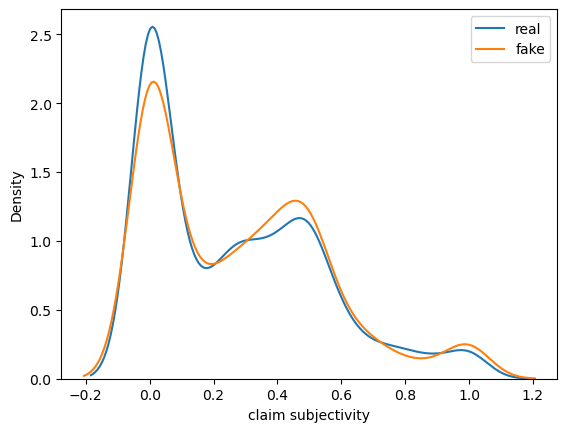

In [93]:
from textblob import TextBlob
X_train['claim subjectivity'] = X_train['claim'].apply(lambda x:TextBlob(x).sentiment.subjectivity)
X_test['claim subjectivity']  = X_test['claim'].apply(lambda x:TextBlob(x).sentiment.subjectivity)
import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(x="claim subjectivity", data=X_train[y_train==0])
sns.kdeplot(x="claim subjectivity", data=X_train[y_train==1])
plt.legend(['real','fake'])
plt.show()

### CountVectorizer `claim source`

In [94]:
X_train['claim source']

3340                                              a tweet
3346                                              a tweet
1547    the Republican response to the State of the Un...
950                             an interview on This Week
3054                                       a TV interview
                              ...                        
1233               a speech to the City Club of Cleveland
467                                    a press conference
4497                a speech at the Democratic convention
3490                         a speech to business leaders
4713                                             a speech
Name: claim source, Length: 2770, dtype: object

In [95]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_src = CountVectorizer(stop_words='english', lowercase=True)
vectorizer_src.fit(X_train['claim source'].values)
src_vec_train = vectorizer_src.transform(X_train['claim source']) # fit & transform on train

# only transform on test
src_vec_test = vectorizer_src.transform(X_test['claim source'].values)

src_vec_train.shape

(2770, 888)

### One-Hot Encoding (OHE) for Categorical Features

- apply on categorical features: ['issue', 'state', 'bio.gender', 'type', 'party']

#### OHE all categorical variables tgt

In [96]:
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import classification_report, confusion_matrix

In [97]:
categorical_variables = ['issue', 'state', 'bio.gender', 'type', 'party']

X_train_categorical = X_train[categorical_variables]
X_test_categorical = X_test[categorical_variables]

# One-hot encoding
enc_lr = OneHotEncoder(handle_unknown="ignore")

transformer_lr = make_column_transformer((enc_lr, categorical_variables), remainder="passthrough")
X_train_categorical = transformer_lr.fit_transform(X_train_categorical)
X_test_categorical = transformer_lr.transform(X_test_categorical)

age_train = X_train['claimmer age'].values.reshape(-1,1)
age_test = X_test['claimmer age'].values.reshape(-1,1)
subjectivity_train = X_train['claim subjectivity'].values.reshape(-1,1)
subjectivity_test = X_test['claim subjectivity'].values.reshape(-1,1)

X_train_vec = np.hstack([age_train, subjectivity_train, src_vec_train.toarray(),tfidf_claim_vec_train])
X_test_vec = np.hstack([age_test, subjectivity_test, src_vec_test.toarray(),tfidf_claim_vec_test])

# then combine with the numerical matrices of the other features 
X_train_combined = np.hstack([X_train_vec, X_train_categorical.toarray()])
X_test_combined = np.hstack([X_test_vec, X_test_categorical.toarray()])

In [98]:
columns = ['claimmer age','claim subjectivity']
columns.extend(list(vectorizer_src.vocabulary_.keys()))
columns.extend(list(tfidf_claim_vec.vocabulary_.keys()))
lr_cols = transformer_lr.transformers_[0][1].categories_ #issue, state, bio.gender, type, party
for i in range(5):
    columns.extend(lr_cols[i])


In [99]:
columns.__len__()

7209

In [100]:
X_train_combined.shape, X_test_combined.shape

((2770, 7209), (1188, 7209))

In [101]:
y_train.shape,X_train_combined.shape

((2770,), (2770, 7209))

In [102]:
df_train = pd.DataFrame(data=X_train_combined, columns=columns)
df_train['accuracy'] = y_train.values
df_train.to_csv("train bio.csv")
df_test = pd.DataFrame(data=X_test_combined, columns=columns)
df_test['accuracy'] = y_test.values
df_test.to_csv("test bio.csv")